### 3. Classifiers

This notebook to classify the probability of fake news traveling from A to B.

In [1]:
ls data

ClassificationModelInput.csv  pol_agg_new.csv
FacebookOnly.csv              politifact.csv*
emergent.csv*                 politifact_clean.csv
fake_localcentralities.csv    real_localcentralities.csv
key_mutuality_roshan.csv      snopes.csv*
keys.csv


In [3]:
%pylab inline
import pandas as pd, pyprind

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,make_scorer

Populating the interactive namespace from numpy and matplotlib


In [4]:
plt.style.use('ggplot')

In [5]:
d=pd.read_csv('data/ClassificationModelInput.csv')
d['Label']=d['Label'].map({0:1, 1:0})
sum(sum(d.isnull())) #No NA
print(d.columns)
d=d.rename(index=str, columns={"page_url": "volume"})

Index(['Source', 'Destination', 'Monday', 'Elections', 'Military', 'Thursday',
       'Religion', 'Friday', 'Saturday', 'TRUE', 'History', 'Tuesday',
       'Wednesday', 'Sunday', 'page_url', 'Health Care', 'FALSE',
       'jaccard_coeff_connection', 'Neighbor_connection',
       'jaccard_coeff_common_destination', 'Neighbor_common_destination',
       'jaccard_coeff_common_source', 'Neighbor_common_source',
       'SourceSite_outdeg_real', 'DestSite_outdeg_real',
       'SourceSite_outdeg_fake', 'DestSite_outdeg_fake',
       'SourceSite_indeg_fake', 'DestSite_indeg_fake', 'DestSite_indeg_real',
       'SourceSite_indeg_real', 'mutuality_ind', 'MedianPolarityScore',
       'Label'],
      dtype='object')


In [7]:
features=['Monday','Thursday','Friday', 'Saturday', 'Tuesday',
       'Wednesday', 'Sunday',
       'jaccard_coeff_connection', 'Neighbor_connection',
       'jaccard_coeff_common_destination', 'Neighbor_common_destination',
       'jaccard_coeff_common_source', 'Neighbor_common_source',
       'SourceSite_outdeg_fake', 'DestSite_outdeg_fake',
       'SourceSite_indeg_fake', 'DestSite_indeg_fake', 'mutuality_ind',
         'MedianPolarityScore']

In [8]:
for col in ['Monday', 'Tuesday', 'Wednesday', 
                            'Thursday','Friday', 'Saturday', 'Sunday']:
    mean = d[col].mean()
    std = d[col].std()
    if std != 0:
        d[col] = d[col].apply(lambda row: (row - mean)/std)
        d[col] = d[col].apply(lambda row: math.log(row+2))
    else:
        d[col] = 0
        
#d['Label'] = d['FAKE']/(d['TRUE'] + d['FAKE'])
#Check for class imblanace
#print(float(sum(d['Label']==0))/len(d))

In [9]:
d.head()

,Source,Destination,Monday,Elections,Military,Thursday,Religion,Friday,Saturday,TRUE,...,DestSite_outdeg_real,SourceSite_outdeg_fake,DestSite_outdeg_fake,SourceSite_indeg_fake,DestSite_indeg_fake,DestSite_indeg_real,SourceSite_indeg_real,mutuality_ind,MedianPolarityScore,Label
0,www.facebook.com,www.politifact.com,2.635807,0,0,2.034849,0,1.281630,0,0,...,0.0,225,35.0,10.0,75,7,1.0,1.0,0.0000,1
1,nationalreport.net,www.whitehouse.gov,0.493258,0,0,3.126103,0,0.439503,0,0,...,0.0,25,0.0,4.0,23,5,0.0,0.0,0.5106,1
2,www.naturalnews.com,www.cdc.gov,0.493258,0,0,0.468457,0,0.439503,0,0,...,0.0,17,0.0,0.0,18,0,0.0,0.0,-0.8834,1
3,www.facebook.com,www.snopes.com,0.493258,0,0,0.468457,0,1.732201,0,1,...,0.0,225,6.0,10.0,33,1,1.0,0.0,0.0000,1
4,www.infowars.com,www.cdc.gov,0.493258,0,0,0.468457,0,0.439503,0,0,...,0.0,21,0.0,3.0,18,0,0.0,0.0,-0.6808,1


In [44]:
sum(facebook['Source'].str.contains('facebook'))/len(facebook)

0.94886363636363635

In [10]:
facebook=d[(d['Source'].str.contains('facebook')) | (d['Destination'].str.contains('facebook'))]

#Ready for model
X=facebook[features]
Y=facebook['Label']
facebook['Monday'].head()

0     2.635807
3     0.493258
6     2.053624
9     1.305752
12    1.305752
Name: Monday, dtype: float64

In [14]:
sum(Y==0)/len(Y)

0.13068181818181818

In [15]:
len(Y)

176

In [20]:
#Random Forest, GBM

#Make AUC the performance metric
from sklearn.linear_model import LogisticRegression

models = {'RF':{'model':RandomForestClassifier(),
                     'Params':{'n_estimators':range(30,50,5),
                              'max_depth':range(2,5),
                              'class_weight': ['balanced']}},
                
         'GBM':{'model':GradientBoostingClassifier(),
                     'Params':{'n_estimators':range(30,50,5),
                               'max_depth':range(2,5),
                               'learning_rate':linspace(0.1,0.3,num=10)}},
          
          'Logistic':{'model':LogisticRegression(),
                   'Params':{'C':linspace(0.1,1,5),
                            'penalty':['l1','l2']}},
         }

In [21]:
print('Number of features:', len(X.columns))
print('Number of records', len(X))

#facebook.to_csv('data/FacebookOnly.csv',index=False)

Number of features: 19
Number of records 176


In [31]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=700)

def modeleva(cvfolds):
    allmodels={}
    for model in models.keys():
        grid = GridSearchCV(estimator=models[model]['model'], 
                            param_grid=models[model]['Params'],
                            cv=cvfolds, n_jobs=-1,scoring='roc_auc')
        modelstats={}
        modelstats['model']=grid.fit(X_train, y_train)
        modelstats['best_estimator']=modelstats['model'].best_estimator_
        modelstats['best_score']=modelstats['model'].best_score_
        allmodels[model]=modelstats
        del modelstats
        print(model)
    results=pd.DataFrame.from_dict(allmodels).T.sort_values(by='best_score')
    results=results.reset_index()
    return(results)

In [32]:
allresults=modeleva(5)
allresults

RF
GBM
Logistic


,index,best_estimator,best_score,model
0,Logistic,"LogisticRegression(C=0.10000000000000001, clas...",0.753361,"GridSearchCV(cv=5, error_score='raise',\n ..."
1,RF,"(DecisionTreeClassifier(class_weight=None, cri...",0.910182,"GridSearchCV(cv=5, error_score='raise',\n ..."
2,GBM,([DecisionTreeRegressor(criterion='friedman_ms...,0.931765,"GridSearchCV(cv=5, error_score='raise',\n ..."


In [33]:
bestmodel=allresults['best_estimator'][2]
bestscore=allresults['best_score'][2]
print(bestmodel)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.29999999999999999, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=30, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


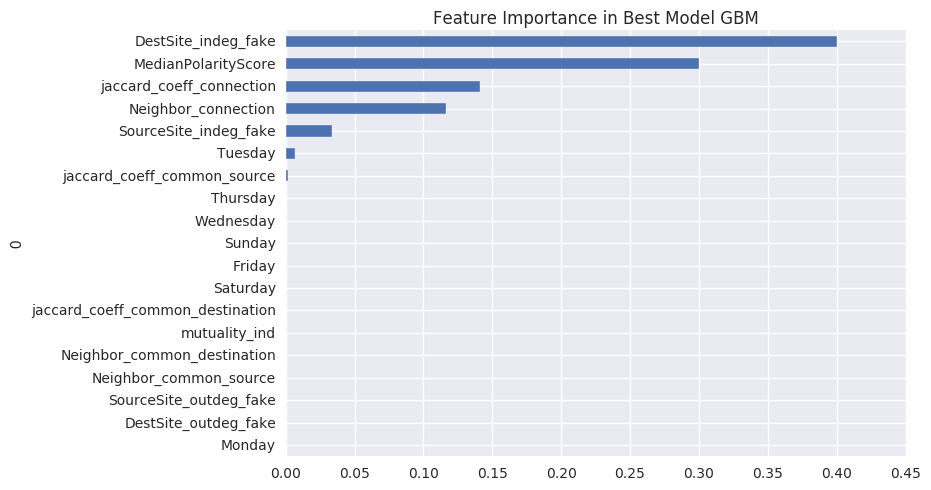

In [40]:
features_df=pd.DataFrame(list(zip(features,
                               bestmodel.feature_importances_)))
features_df=features_df.set_index(features_df[0]).sort_values(by=1)
features_df[1].plot(kind='barh', legend=False)
#pd.DataFrame.from_dict(features).plot(kind='barh')
title('Feature Importance in Best Model GBM')

## ROC

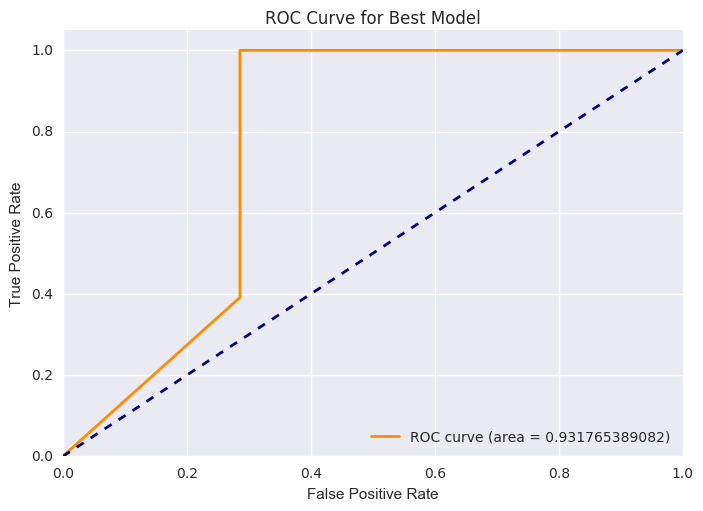

In [35]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=942)

y_pred = bestmodel.predict_proba(X_test)
# a = np.array(y_test)[:10] + 1
# b = y_pred[:,1][:10]
# b = array([0.8,0.1,0.1,0.5,0.5,0.5,0.7,0.3,0.2,0.1])
# fpr, tpr, thresholds = roc_curve(a,b, pos_label=2)
# tpr
fpr, tpr, thresholds = roc_curve(np.array(y_test)+1, y_pred[:,1], pos_label=2)
tpr
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = ' + str(bestscore) + ')')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model')
plt.legend(loc="lower right")
plt.show()

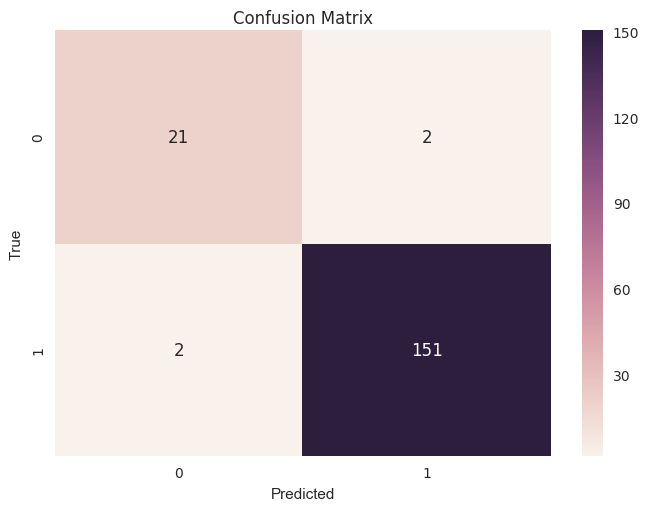

In [39]:
import seaborn as sns

con_mat=confusion_matrix(Y.tolist(), bestmodel.predict(X))
sns.heatmap(con_mat, annot=True, fmt='g')
xlabel('Predicted')
ylabel('True')
title("Confusion Matrix")

### Probability

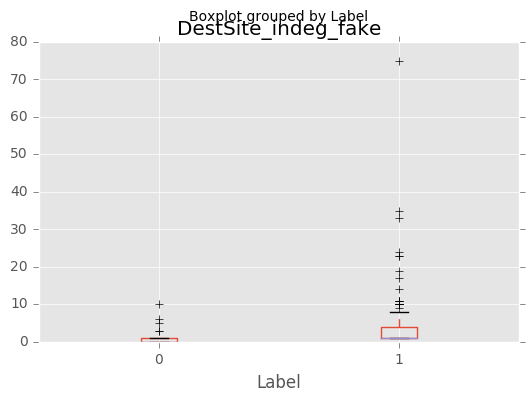

In [255]:
#scatter(facebook['Label'],facebook['DestSite_indeg_fake'])
facebook.boxplot(column='DestSite_indeg_fake',by='Label')

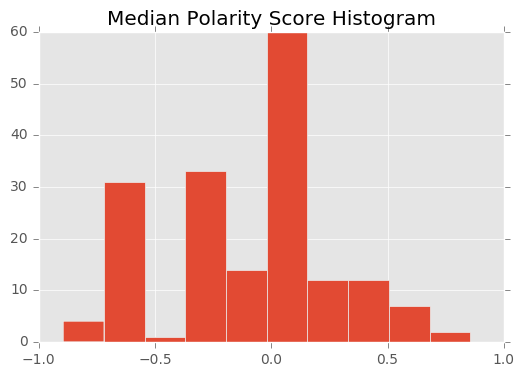

In [256]:
facebook['MedianPolarityScore'].hist()
title('Median Polarity Score Histogram')

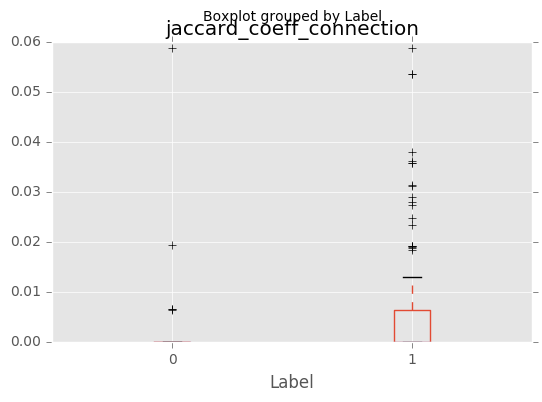

In [268]:
facebook.boxplot(column='jaccard_coeff_connection',by='Label')